In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from statsforecast import StatsForecast
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import TimeSeriesSplit
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA

In [2]:
historic_df = pd.read_csv(r'Base de Dados//Dados Históricos - Ibovespa.csv', parse_dates=['Data'], index_col='Data')
historic_df = historic_df.sort_index()

historic_df['Var%'] = historic_df['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)

historic_df['Vol.'] = historic_df['Vol.'].str.replace(',', '.')
historic_df['Vol.'] = historic_df['Vol.'].apply(
    lambda x: float(str(x)[:-1].replace(',', '.'))/1_000  if str(x)[-1] == 'K'
    else float(str(x)[:-1].replace(',', '.')) if str(x)[-1] == 'M'
    else float(str(x)[:-1].replace(',', '.')) * 1_000 if str(x)[-1] == 'B'
    else float(str(x).replace(',', '.'))/1_000_000 )

historic_df.rename(columns={'Vol.':'Vol (M)'}, inplace=True)

C:\Users\dhlui\AppData\Local\Temp\ipykernel_6088\3671609938.py:1: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  historic_df = pd.read_csv(r'Base de Dados//Dados Históricos - Ibovespa.csv', parse_dates=['Data'], index_col='Data')


In [3]:
historic_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2023-01-02 to 2025-03-17
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    550 non-null    float64
 1   Abertura  550 non-null    float64
 2   Máxima    550 non-null    float64
 3   Mínima    550 non-null    float64
 4   Vol (M)   550 non-null    float64
 5   Var%      550 non-null    float64
dtypes: float64(6)
memory usage: 30.1 KB


In [ ]:
historic_df.describe()

,Último,Abertura,Máxima,Mínima,Vol (M),Var%
count,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000
mean,121.529976,121.491845,122.316922,120.733245,918.218364,0.036691
std,9.002357,9.007406,8.917136,9.071973,3043.315581,0.974496
min,97.926000,97.926000,99.258000,96.997000,4.330000,-3.150000
25%,115.940000,115.910750,116.929750,115.500250,9.070000,-0.577500
50%,124.307000,124.247000,124.898500,123.414500,10.760000,0.015000
75%,128.158000,128.154000,128.983000,127.405500,13.275000,0.650000
max,137.344000,137.349000,137.469000,136.664000,24870.000000,4.290000


In [65]:
delta_date = historic_df['Último'].iloc[-1] - historic_df['Último'].iloc[0]
line_trend = delta_date/(len(historic_df)-1)

historic_df['Trend'] = (line_trend * range(len(historic_df))) + historic_df['Último'].iloc[0]

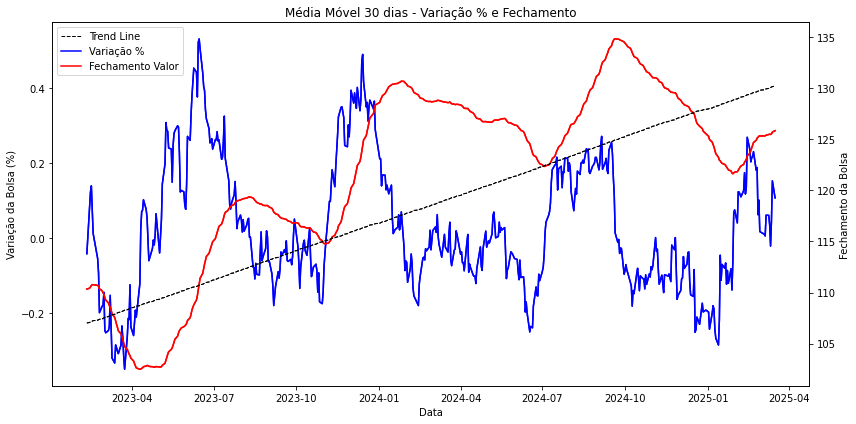

In [72]:
fig, ax = plt.subplots(figsize=(12,6))

# Plot da média móvel da variação percentual no eixo primário
line1, = ax.plot(historic_df.index, historic_df['Var%'].rolling(window=30).mean(), color='blue', label='Variação %')
ax.plot(historic_df.index, historic_df['Var%'].rolling(window=30).mean(), color='blue', label='Variação %')
ax.set_xlabel('Data')
ax.set_ylabel('Variação da Bolsa (%)')
ax.tick_params(axis='y')

# Criação do segundo eixo Y (para o fechamento da bolsa)
ay = ax.twinx()
line2, = ay.plot(historic_df.index, historic_df['Último'].rolling(window=30).mean(), color='red', label='Fechamento Valor')
ay.plot(historic_df.index, historic_df['Último'].rolling(window=30).mean(), color='red', label='Fechamento Valor')
line3, = ay.plot(historic_df.index, historic_df['Trend'].rolling(window=30).mean(), 
                 color='black', linewidth=1, linestyle='--', label='Trend Line')
ay.plot(historic_df.index, historic_df['Trend'].rolling(window=30).mean(),
         color='black', linewidth=1, linestyle='--', label='Trend Line')
ay.set_ylabel('Fechamento da Bolsa')
ay.tick_params(axis='y')

# Título e layout
lines = [line3, line1, line2]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')

plt.title('Média Móvel 30 dias - Variação % e Fechamento')
fig.tight_layout()

# Exibir gráfico
plt.show()

,Último,Abertura,Máxima,Mínima,Vol (M),Var%,day,week_of_year,month,year,...,lag_38,lag_39,lag_40,rolling_mean_40,rolling_std_40,ema_40,ema_std_40,fourier_sin,fourier_cos,Trend
Data,,,,,,,,,,,,,,,,,,,,,
2023-01-02,106.376,109.734,109.734,105.981,8.13,-3.06,2,1,1,2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,106.376000
2023-01-03,104.166,106.377,106.684,103.852,14.47,-2.08,3,1,1,2023,...,NaN,NaN,NaN,NaN,NaN,106.376000,NaN,0.011424,0.999935,106.420469
2023-01-04,105.334,104.167,105.627,103.915,14.45,1.12,4,1,1,2023,...,NaN,NaN,NaN,NaN,NaN,105.243375,1.562706,0.022846,0.999739,106.464938
2023-01-05,107.641,105.336,107.743,105.333,15.51,2.19,5,1,1,2023,...,NaN,NaN,NaN,NaN,NaN,105.275106,1.092385,0.034265,0.999413,106.509407
2023-01-06,108.964,107.642,109.433,107.642,12.63,1.23,6,1,1,2023,...,NaN,NaN,NaN,NaN,NaN,105.911660,1.498257,0.045680,0.998956,106.553876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-11,123.507,124.519,124.625,122.636,8810.00,-0.81,11,11,3,2025,...,119.299,119.007,118.856,124.468900,2.402360,124.898119,2.465666,-0.057089,0.998369,130.611655
2025-03-12,123.864,123.507,124.048,122.969,8250.00,0.29,12,11,3,2025,...,122.650,119.299,119.007,124.585175,2.230108,124.830259,2.423850,-0.045680,0.998956,130.656124
2025-03-13,125.637,123.863,125.774,123.590,11260.00,1.43,13,11,3,2025,...,121.234,122.650,119.299,124.706600,2.042975,124.783125,2.373372,-0.034265,0.999413,130.700593


In [ ]:

historic_df

,Último,Abertura,Máxima,Mínima,Vol (M),Var%,day,week_of_year,month,year,...,lag_38,lag_39,lag_40,rolling_mean_40,rolling_std_40,ema_40,ema_std_40,fourier_sin,fourier_cos,Trend
Data,,,,,,,,,,,,,,,,,,,,,
2023-01-02,106.376,109.734,109.734,105.981,8.13,-3.06,2,1,1,2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN
2023-01-03,104.166,106.377,106.684,103.852,14.47,-2.08,3,1,1,2023,...,NaN,NaN,NaN,NaN,NaN,106.376000,NaN,0.011424,0.999935,106.420469
2023-01-04,105.334,104.167,105.627,103.915,14.45,1.12,4,1,1,2023,...,NaN,NaN,NaN,NaN,NaN,105.243375,1.562706,0.022846,0.999739,104.254938
2023-01-05,107.641,105.336,107.743,105.333,15.51,2.19,5,1,1,2023,...,NaN,NaN,NaN,NaN,NaN,105.275106,1.092385,0.034265,0.999413,105.467407
2023-01-06,108.964,107.642,109.433,107.642,12.63,1.23,6,1,1,2023,...,NaN,NaN,NaN,NaN,NaN,105.911660,1.498257,0.045680,0.998956,107.818876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-11,123.507,124.519,124.625,122.636,8810.00,-0.81,11,11,3,2025,...,119.299,119.007,118.856,124.468900,2.402360,124.898119,2.465666,-0.057089,0.998369,148.754655
2025-03-12,123.864,123.507,124.048,122.969,8250.00,0.29,12,11,3,2025,...,122.650,119.299,119.007,124.585175,2.230108,124.830259,2.423850,-0.045680,0.998956,147.787124
2025-03-13,125.637,123.863,125.774,123.590,11260.00,1.43,13,11,3,2025,...,121.234,122.650,119.299,124.706600,2.042975,124.783125,2.373372,-0.034265,0.999413,148.188593


In [73]:
historic_var_df = historic_df[['Var%']]
X = historic_var_df[['Var%']].values

result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")


Teste ADF
Teste Estatístico: -23.161072729288584
P-Value: 0.0
Valores críticos:
	1%: -3.4423174665535385
	5%: -2.866818952732754
	10%: -2.569581505602171


In [77]:
# Define training and test sets
train_end = '2025-03-01'
df_train = historic_df.loc[:train_end]
df_test = historic_df.loc[train_end:]

### CRIANDO O NAIVE PREDICT

In [106]:
naive_pred = pd.Series(index=historic_df.index, dtype='float64')
naive_pred.loc[df_train.index] = historic_df['Último'].shift(1).loc[df_train.index]
last_train_value = historic_df['Último'].rolling(window=30).mean().loc[df_train.index[-1]]
naive_pred.loc[df_test.index] = last_train_value


# Evaluation
from sklearn.metrics import mean_squared_error

mse_naive = mean_squared_error(df_test['Último'][1:], naive_pred.loc[df_test.index][1:])
print(f'Naive Baseline MSE: {mse_naive}')

Naive Baseline MSE: 6.719223034444435


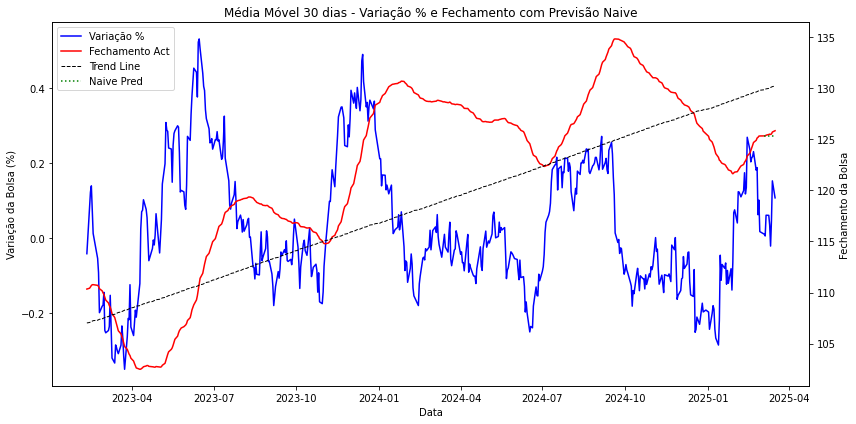

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

# Plot da média móvel da variação percentual no eixo primário
line1, = ax.plot(historic_df.index, historic_df['Var%'].rolling(window=30).mean(), color='blue', label='Variação %')
ax.set_xlabel('Data')
ax.set_ylabel('Variação da Bolsa (%)')
ax.tick_params(axis='y')

# Segundo eixo Y - fechamento
ay = ax.twinx()

# Fechamento real (rolling)
line2, = ay.plot(historic_df.index, historic_df['Último'].rolling(window=30).mean(), color='red', label='Fechamento Act')

# Linha de tendência (rolling)
line3, = ay.plot(historic_df.index, historic_df['Trend'].rolling(window=30).mean(), 
                 color='black', linewidth=1, linestyle='--', label='Trend Line')

# Previsão Naive SOMENTE no período de teste (sem rolling para mostrar a linha de previsão)
line4, = ay.plot(df_test.index, naive_pred.loc[df_test.index], color='green', linestyle=':', linewidth=1.5, label='Naive Pred')

ay.set_ylabel('Fechamento da Bolsa')
ay.tick_params(axis='y')

# Título e legenda
lines = [line1, line2, line3, line4]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')
plt.title('Média Móvel 30 dias - Variação % e Fechamento com Previsão Naive')
fig.tight_layout()

plt.show()

### CRIANDO XGBoost PREDICT

Period: 550.0 days


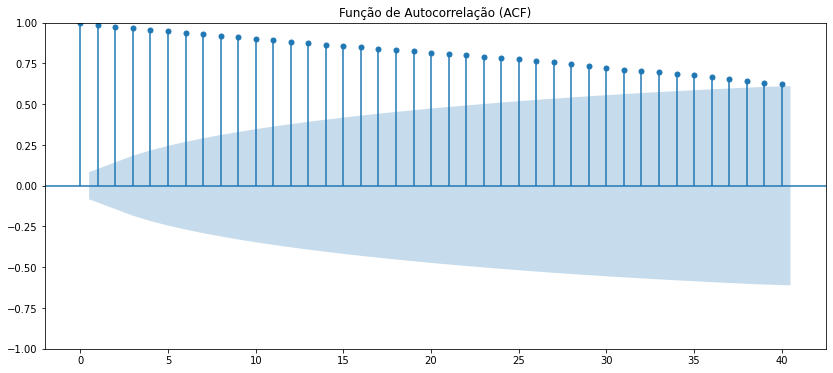

In [9]:
historic_df['day'] = historic_df.index.day
historic_df['week_of_year'] = [dt.weekofyear for dt in historic_df.index]
historic_df['month'] = historic_df.index.month
historic_df['year'] = historic_df.index.year


# Plot da ACF e PACF da série diferenciada
plt.figure(figsize=(14, 6))
plot_acf(historic_df["Último"].dropna(), ax=plt.gca(), lags=40)
plt.title("Função de Autocorrelação (ACF)")


n_lags = 40
for lag in range(1, n_lags + 1):
    historic_df[f'lag_{lag}'] = historic_df['Último'].shift(lag)


# Rolling statistics
historic_df[f'rolling_mean_{n_lags}'] = historic_df['Último'].rolling(window=n_lags).mean().shift(1)
historic_df[f'rolling_std_{n_lags}'] = historic_df['Último'].rolling(window=n_lags).std().shift(1)

# Exponential Moving Averages (EMA)
historic_df[f'ema_{n_lags}'] = historic_df['Último'].ewm(span=n_lags).mean().shift(1)
historic_df[f'ema_std_{n_lags}'] = historic_df['Último'].ewm(span=n_lags).std().shift(1)



from scipy.signal import periodogram
frequency, power = periodogram(historic_df['Último'].dropna(), fs=1)

freq = frequency[np.argmax(power)]
period = 1 / freq

print(f'Period: {period} days')

historic_df['fourier_sin'] = np.sin(2 * np.pi * freq * np.arange(len(historic_df)))
historic_df['fourier_cos'] = np.cos(2 * np.pi * freq * np.arange(len(historic_df)))


predictors = [
    'day',
    'week_of_year',
    'month',
    'year',
    *['lag_{}'.format(i) for i in range(1, n_lags + 1)],
    'rolling_mean_{n_lags}'.format(n_lags=n_lags),
    'rolling_std_{n_lags}'.format(n_lags=n_lags),
    'ema_{n_lags}'.format(n_lags=n_lags),
    'ema_std_{n_lags}'.format(n_lags=n_lags),
    'fourier_sin',
    'fourier_cos',
]

In [91]:
# Define features and target
X_train = df_train[predictors]
y_train = df_train['Último']
X_test = df_test[predictors]
y_test = df_test['Último']

# TimeSeriesSplit for validation
tscv = TimeSeriesSplit(n_splits=100)
xgb = XGBRegressor(objective='reg:squarederror')

# Train with cross-validation
xgb_models = []
mse = []
count = 0
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    xgb.fit(X_tr, y_tr)
    val_pred = xgb.predict(X_val)
    # print(f'{count} Validation MSE: {mean_squared_error(y_val, val_pred)}')
    count = count + 1 
    mse.append(mean_squared_error(y_val, val_pred))
    xgb_models.append(xgb)

best_model_idx = mse.index(min(mse))
print(f'Best Model Idx: {best_model_idx}')

xgb = xgb_models[best_model_idx]

# Predict on the test set
xgb_pred = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, xgb_pred)
print(f'XGBoost MSE: {mse_xgb}')

Best Model Idx: 85
XGBoost MSE: 2.4276048568343946


array([122.80953 , 124.23054 , 124.769135, 125.48421 , 125.04763 ,
       124.91958 , 124.39585 , 125.81219 , 128.5734  ], dtype=float32)